In [392]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import reservoirpy as rp
from reservoirpy.nodes import Reservoir, Ridge, Input
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [393]:
# librairies display version
print(pd.__version__,mpl.__version__,sns.__version__,tf.__version__,np.__version__)


1.5.3 3.7.1 0.13.0 2.13.1 1.24.2


In [394]:
df = pd.read_csv('data.csv')

# remove the date column
date_time = df.pop('date')

Y = df.pop('incidents')
X = df


In [395]:
months = pd.to_datetime(date_time,
               format='%Y-%m-%d').dt.month

In [396]:
df.head()

,"('temperature', 'mean')","('temperature', 'max')","('temperature', 'min')","('humidite', 'mean')","('humidite', 'max')","('humidite', 'min')","('nuages', 'mean')","('nuages', 'max')","('nuages', 'min')"
0,8.407479,10.476465,5.921381,86.976287,96.8684,72.3197,88.009513,100.0,46.87500
1,10.482559,13.003564,8.543604,89.939588,96.2094,81.1347,91.015629,100.0,35.93750
2,10.108455,12.519678,8.909326,94.035604,97.8528,89.3497,95.084633,100.0,67.18750
3,8.958734,12.460107,5.731348,86.352908,92.5699,68.4599,73.518883,100.0,0.00000
4,7.104425,8.300439,5.926172,90.596867,96.4792,78.9225,66.927081,100.0,5.46875


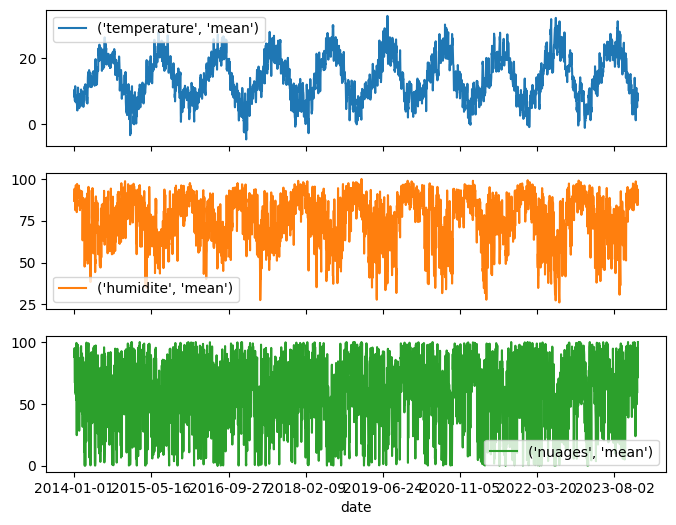

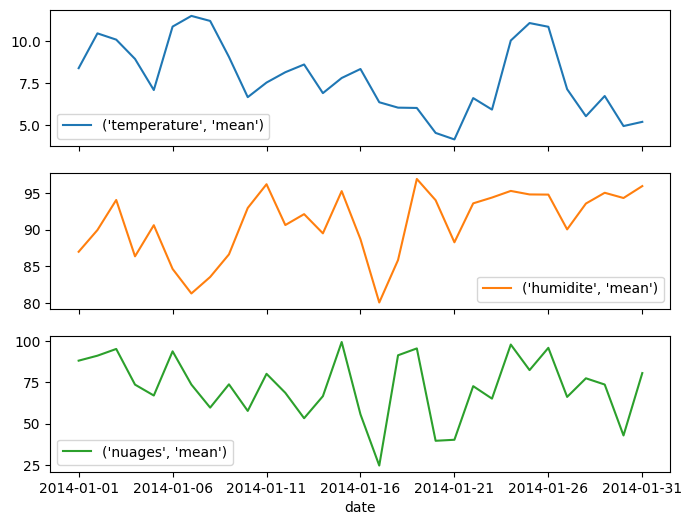

In [397]:
plot_cols = ["('temperature', 'mean')", "('humidite', 'mean')", "('nuages', 'mean')"]
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:31]
plot_features.index = date_time[:31]
_ = plot_features.plot(subplots=True)

In [398]:
# split train and test (test = last 300 days, train = rest)
# X = ('temperature', 'mean')	('temperature', 'max')	('temperature', 'min')	('humidite', 'mean')	('humidite', 'max')	('humidite', 'min')	('nuages', 'mean')	('nuages', 'max')	('nuages', 'min')
# Y = incidents (0 or 1 or 2)
train_df = df[:-300]
test_df = df[-300:]
train_labels = Y[:-300]
test_labels = Y[-300:]

# normalize data
train_mean = train_df.mean()
train_std = train_df.std()
train_df = (train_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

train_data = np.array(train_df)
train_labels = np.array(train_labels)
test_data = np.array(test_df)
test_labels = np.array(test_labels)
# transform labels to one hot
train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

print(train_labels)
print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)


[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]
(3353, 9)
(3353, 2)
(300, 9)
(300, 2)


In [399]:
# create a model to predict if today is a risky day, very risky day or not (0, 1, 2) using reservoirpy

# create a reservoir
source = Input()
reservoir = Reservoir(100, sr=0.9, lr=0.1)
readout = Ridge(ridge=1e-6)

model = [source >> reservoir, source] >> readout

# run to get the reservoir states
states = reservoir.run(train_data)

# select only the month of may to october to train the model
filtered_states = []
filtered_train_labels = []
for i in range(len(states)):
    if months[i] >= 5 and months[i] <= 10:
        filtered_states.append(states[i])
        filtered_train_labels.append(train_labels[i])
        
        

# train the model
readout.fit(filtered_states, filtered_train_labels)

# run the model on the test data
Y_pred = readout.run(reservoir.run(test_data))

# filter Y_pred to only keep the months of may to october
filtered_Y_pred = []
filtered_test_labels = []
date = []
for i in range(len(Y_pred)):
    if months[len(train_labels)+i] >= 5 and months[len(train_labels)+i] <= 10:
        filtered_Y_pred.append(Y_pred[i])
        filtered_test_labels.append(test_labels[i])
        date.append(date_time[len(train_labels)+i])

Running Reservoir-48:   0%|          | 0/3353 [00:00<?, ?it/s]

Running Ridge-48: 100%|██████████| 300/300 [00:00<00:00, 43791.02it/s]


In [400]:
Y_pred_class = [np.argmax(y_p) for y_p in filtered_Y_pred]
Y_test_class = [np.argmax(y_t) for y_t in filtered_test_labels]

score = accuracy_score((Y_test_class), (Y_pred_class))

print("Accuracy: ", f"{score * 100:.3f} %")
print("Precision: ", f"{precision_score(Y_test_class, Y_pred_class, average='macro') * 100:.3f} %")
print("Recall: ", f"{recall_score(Y_test_class, Y_pred_class, average='macro') * 100:.3f} %")
print("F1: ", f"{f1_score(Y_test_class, Y_pred_class, average='macro') * 100:.3f} %")


Accuracy:  83.152 %
Precision:  59.017 %
Recall:  56.667 %
F1:  57.455 %


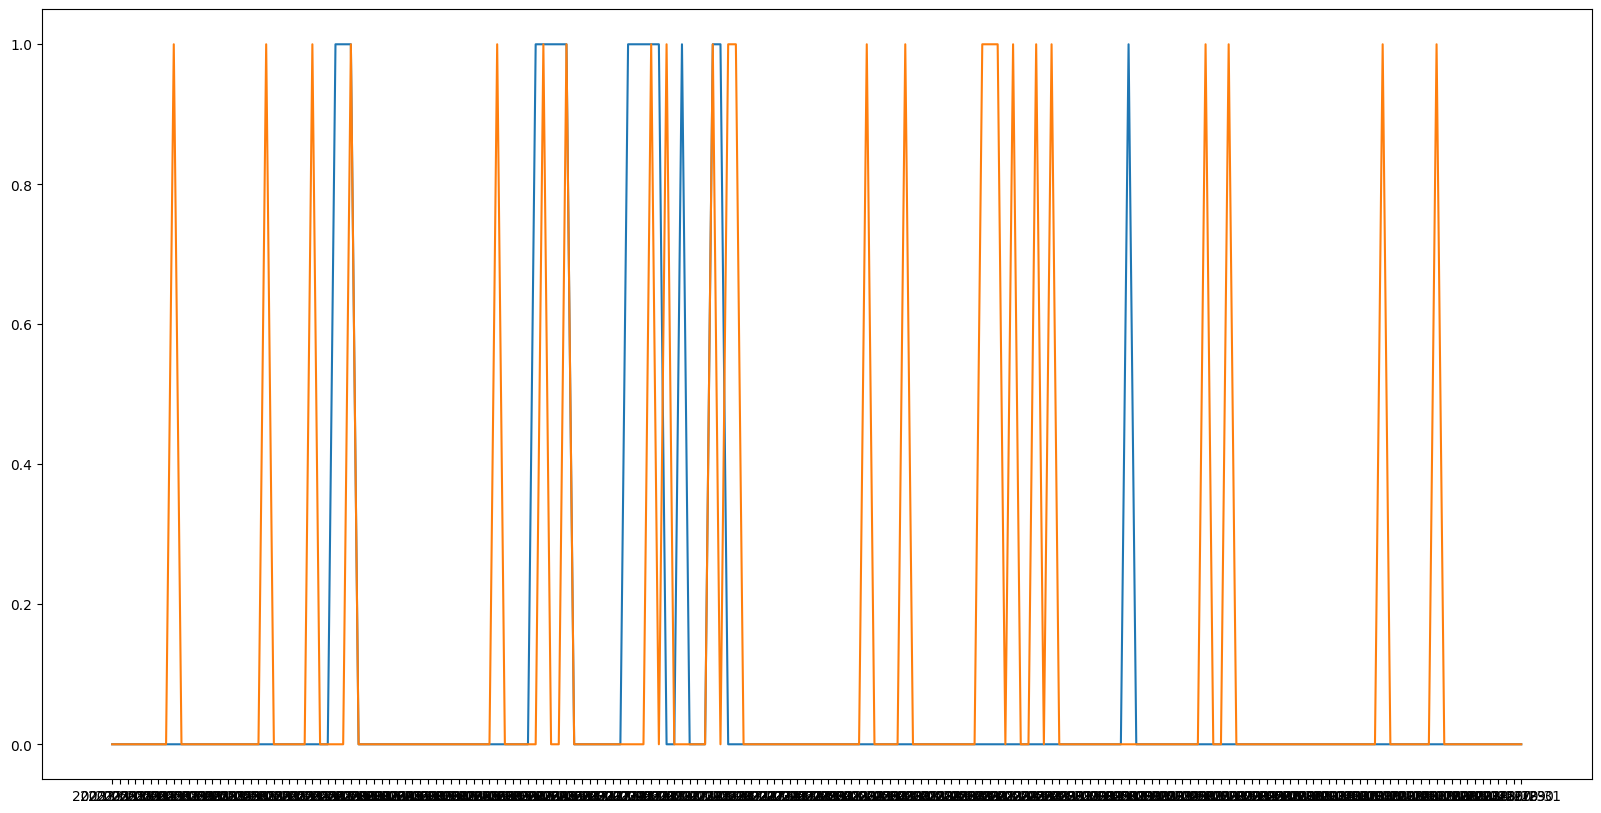

In [401]:
plt.figure(figsize=(20,10))
plt.plot(date, Y_pred_class, label="prediction")
plt.plot(date, Y_test_class, label="true")

